In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('weather-2021-preprocessed.csv')
df.head()

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index,Condition
0,2021-01-01 00:00:00,75,75.0,75.0,61.0,61.0,6.0,8,29.85,Low,0,Cloudy
1,2021-01-01 00:30:00,75,75.0,75.0,61.0,61.0,6.0,7,29.85,Low,0,Cloudy
2,2021-01-01 01:00:00,75,75.0,75.0,61.0,61.0,6.0,7,29.82,Low,0,Cloudy
3,2021-01-01 01:30:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy
4,2021-01-01 02:00:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy


In [3]:
df_copy = df.copy()

In [4]:
df_copy.isnull().sum()

Time                       0
Temperature                0
Heat Index                 2
Temperature Feels Like     2
Dew Point                  2
Humidity                   2
Wind Force                 0
Wind Speed                 0
Pressure                  10
UV Description             0
UV Index                   0
Condition                  0
dtype: int64

In [5]:
missing_cols = df.columns[df.isnull().any()]

In [6]:
mean = df_copy.groupby('Condition').mean()
mean

,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index
Condition,,,,,,,,,
Cloudy,83.087897,89.488255,89.488255,74.489966,77.177116,5.554838,5.766490,29.754057,2.028936
Fair,82.007961,86.613595,86.613595,71.213411,71.656767,5.625842,6.134415,29.795993,1.859767
Fog / Haze,78.539326,80.966292,80.966292,74.528090,89.134831,1.593933,2.359551,29.813596,1.337079
Rain,80.347041,85.548193,85.548193,76.720884,89.754016,4.364343,6.597793,29.723861,1.989970
T-Storm,77.840000,80.990000,80.990000,75.980000,94.400000,2.003500,11.320000,29.731500,1.660000
Thunder,84.829268,93.493827,93.493827,75.864198,75.493827,5.304878,7.536585,29.712073,2.560976


In [7]:
for col in missing_cols:
    df_copy[col] = df_copy[col].fillna(df_copy['Condition'].map(mean[col]))

In [8]:
df_copy.isnull().sum()

Time                      0
Temperature               0
Heat Index                0
Temperature Feels Like    0
Dew Point                 0
Humidity                  0
Wind Force                0
Wind Speed                0
Pressure                  0
UV Description            0
UV Index                  0
Condition                 0
dtype: int64

# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

## A. Mô hình hóa dữ liệu

### Giới thiệu bài toán
Dựa trên việc tìm hiểu về bộ dữ liệu thông qua các quá trình khám phá dữ liệu và đặt các câu hỏi có ý nghĩa cần trả lời, bài toán thích hợp cho bộ dữ liệu này là 'Dự đoán điều kiện thời tiết là nhiều mây hay không?'.

Bài toán được chọn do bộ dữ liệu có các thuộc tính biểu thị chỉ số khí hậu (numerical columns) tương ứng với cột điều kiện thời tiết (categorical column). Tuy nhiên, ở cột điều kiện thời tiết, giá trị `Cloudy` chiếm nhiều hơn hẳn các giá trị còn lại, nên việc bài toán dự đoán là nhiều mây (Cloudy) hay không (các trường hợp còn lại) sẽ phù hợp và tránh trường hợp dữ liệu bị lệch (biased) gây ảnh hưởng đến hiệu suất của mô hình.

### Lý do lựa chọn thuật toán phân lớp (Classification Algorithm)
...

### Phân tích lựa chọn ra những đặc trưng có mức độ liên quan cao, có tính quan trọng cho bài toán và thực hiện các tiền xử lý cần thiết
...



Thay đổi tập giá trị ở cột `Condition`

In [9]:
condition = {'Cloudy':'Cloudy',
             'Fair':'Not Cloudy',
             'Rain':'Not Cloudy',
             'Fog / Haze':'Not Cloudy',
             'T-Storm':'Not Cloudy',
             'Thunder':'Not Cloudy'}

In [10]:
df_copy['Condition'] = df_copy['Condition'].map(condition)
set(df_copy['Condition'].to_list())

{'Cloudy', 'Not Cloudy'}

Chỉ lấy tháng

In [11]:
df_copy['Time'] = pd.to_datetime(df_copy['Time'])
df_copy['Time'] = df_copy['Time'].dt.month

Từ quá trình đặt các câu hỏi có ý nghĩa cần trả lời, ta nhận thấy `UV Description` và `UV Index` có mức độ tương quan nhất định, chỉ số UV có thể biểu thị cho mức độ UV nên việc có cột `UV Description` là không cần thiết.

In [12]:
# Separate the dependent and independent features
df_copy = df_copy.drop('UV Description', axis=1)

In [13]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
df_copy['Condition'] = le.fit_transform(df_copy['Condition'])
df_copy

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,0,0
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,0,0
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,0,0
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,0,0
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,0,0


# ...

## B. Huấn luyện và đánh giá mô hình

Để xác thực kỹ lưỡng các siêu tham số của mô hình, nhóm đã chọn kỹ thuật sử dụng tập kiểm định (validation set).

Tập kiểm định được đưa ra khỏi tập huấn luyện (training set) và được sử dụng trong quá trình huấn luyện để xác thực độ chính xác của mô hình. Tập kiểm tra (test set) bị tách biệt hoàn toàn cho đến khi mô hình hoàn thành quá trình huấn luyện, nhưng tập kiểm định được sử dụng để xác thực trong quá trình huấn luyện.

Tham khảo: https://stackabuse.com/scikit-learns-traintestsplit-training-testing-and-validation-sets/

In [14]:
X = df_copy[['Time', 'Temperature', 'Heat Index', 'Temperature Feels Like', 'Dew Point', 'Humidity', 'Wind Force', 'Wind Speed', 'Pressure', 'UV Index']]
y = df_copy['Condition']

In [15]:
# Tách dataset thành tập huấn luyện (training set), tập kiểm định (validation set) và tập kiểm tra (test set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)
print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_valid.shape, y_valid.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (12520, 10) (12520,)
Validation set shape:  (1392, 10) (1392,)
Testing set shape:  (3478, 10) (3478,)


### KNN Classification
KNN (K-nearest neighbor) là một trong những thuật toán supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning. Khi training, thuật toán này không học một điều gì từ dữ liệu training (đây cũng là lý do thuật toán này được xếp vào loại lazy learning), mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới. K-nearest neighbor có thể áp dụng được vào cả hai loại của bài toán Supervised learning là Classification và Regression. KNN còn được gọi là một thuật toán Instance-based hay Memory-based learning.

Tham khảo: https://machinelearningcoban.com/2017/01/08/knn/#k-nearest-neighbor

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [17]:
from sklearn import metrics

Kiểm tra độ chính xác của mô hình khi huấn luyện với các giá trị khác nhau của 'k' và sau đó chọn giá trị tốt nhất từ chúng.

In [18]:
# Tính độ chính xác của mô hình với các giá trị 'k' khác nhau
mean_acc = np.zeros(20)
for i in range(1, 21):
    # Huấn luyện mô hình và dự đoán
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat = knn.predict(X_valid)
    mean_acc[i-1] = metrics.accuracy_score(y_valid, yhat)

mean_acc

array([0.76867816, 0.78520115, 0.78735632, 0.79094828, 0.79094828,
       0.79022989, 0.79454023, 0.78807471, 0.78951149, 0.78591954,
       0.78448276, 0.78591954, 0.77801724, 0.78017241, 0.77945402,
       0.77873563, 0.77586207, 0.77083333, 0.77442529, 0.77658046])

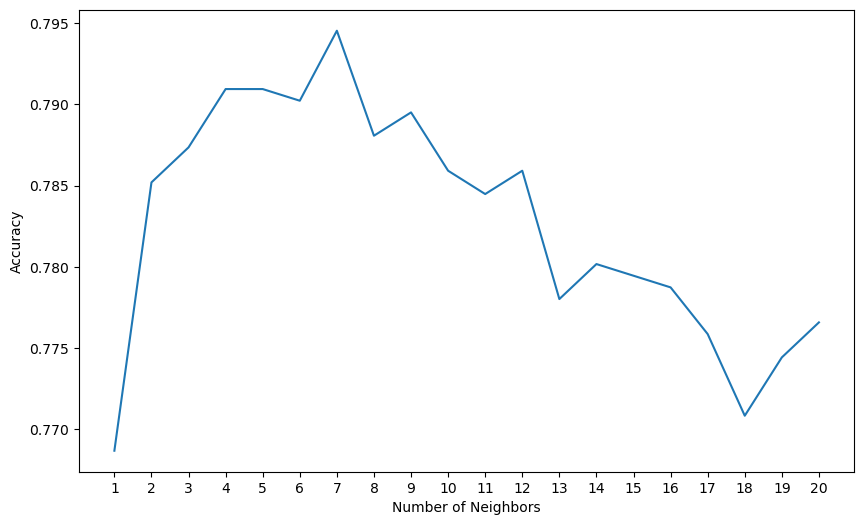

In [19]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, 21), mean_acc)
plt.xticks(np.arange(1, 21, step=1.0))
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Độ chính xác cao nhất với giá trị của 'k' là 7

Báo cáo quá trình tinh chỉnh (fine-tuning process)

Nhóm sử dụng kỹ thuật Exhaustive Grid Search để tối ưu hóa siêu tham số. Một Exhaustive Grid Search sẽ nhận bao nhiêu siêu tham số tùy thích và thử mọi cách kết hợp duy nhất có thể có của các siêu tham số cũng như nhiều xác thực chéo mà ta muốn nó thực hiện. Exhaustive Grid Search là một cách hay để xác định các giá trị siêu tham số tốt nhất để sử dụng, nhưng nó có thể nhanh chóng trở nên tốn thời gian với mọi giá trị tham số bổ sung và xác thực chéo mà bạn thêm vào.

In [20]:
from sklearn.model_selection import GridSearchCV

We will use three hyperparamters- n-neighbors, weights and metric.

n_neighbors: Decide the best k based on the values we have computed earlier.

weights: Check whether adding weights to the data points is beneficial to the model or not. 'uniform' assigns no weight, while 'distance' weighs points by the inverse of their distances meaning nearer points will have more weight than the farther points.

metric: The distance metric to be used will calculating the similarity.

In [21]:
grid_params = {'n_neighbors':range(4, 9),
               'weights':['uniform','distance'],
               'metric':['minkowski','euclidean','manhattan']}

In [22]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [23]:
# Khớp mô hình với tập huấn luyện
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [24]:
# Tìm best score
g_res.best_score_

0.7816295177664401

In [25]:
# Lấy siêu tham số với best score
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

In [26]:
kk
# Sử dụng siêu tham số tốt nhất
knn = KNeighborsClassifier(n_neighbors = 10, weights = 'distance', algorithm = 'brute', metric = 'manhattan')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=10,
                     weights='distance')

In [27]:
# Dự đoán
y_hat = knn.predict(X_train)
yhat = knn.predict(X_valid)
y_knn = knn.predict(X_test)

Đánh giá mô hình

In [28]:
print('Training set accuracy: ', metrics.accuracy_score(y_train, y_hat))
print('Validation set accuracy: ', metrics.accuracy_score(y_valid, yhat))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_knn))

Training set accuracy:  0.9710862619808307
Test set accuracy:  0.7912593444508338


In [29]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_knn))

[[2360  210]
 [ 516  392]]


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2570
           1       0.65      0.43      0.52       908

    accuracy                           0.79      3478
   macro avg       0.74      0.68      0.69      3478
weighted avg       0.78      0.79      0.78      3478



In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv = 5)

In [32]:
print('Model accuracy: ', np.mean(scores))

Model accuracy:  0.538125359401955


Naive Bayes Classification

In [35]:
print(list(range(4, 9)))

[4, 5, 6, 7, 8]
